# Importar librerías 

In [2]:
import os
import cv2
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.applications.vgg19 import VGG19
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten


from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score

# Definición de los paths de los datos

In [3]:
# Ruta de datos de entrenamiento, testeo y validación del modelo
train_path = "data/64x64/train/"
test_path = "data/64x64/test/"
validation_path = "data/64x64/validation/"

img_size = (64, 64)
random.seed(1)

# Conversión de Imágenes a píxeles

negative


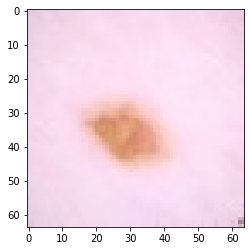

nevus


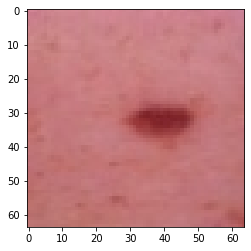

positive


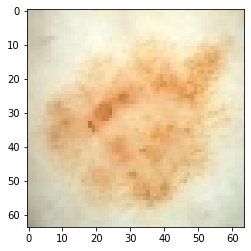

unknown


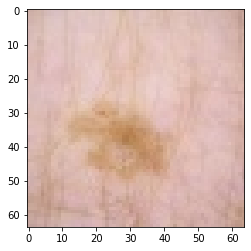

In [5]:
# función para mostrar 1 imágen aleatoria por clase 
for folder in os.listdir(train_path):
    sub_path = train_path + folder
    print(folder)
    for i in range(1):
        img_name = os.listdir(sub_path)[random.randrange(0, len(sub_path))]
        temp_path = sub_path + "/" + img_name
        img = mpimg.imread(temp_path)
        implot = plt.imshow(img)
        plt.show()


In [8]:
def image_to_array(path):
    data = []
    for folder in os.listdir(path):
        sub_path=path+"/"+folder

        for img in os.listdir(sub_path):
            image_path=sub_path+"/"+img
            img_arr=cv2.imread(image_path)
            data.append(img_arr)
            
    return data

In [9]:
train_data = image_to_array(train_path)
test_data = image_to_array(test_path)
validation_data = image_to_array(validation_path)

# Normaización 

In [10]:
x_train = np.array(train_data)/255.0
x_test = np.array(test_data)/255.0
x_validation = np.array(validation_data)/255.0

# Definición de las variables de entrada y salida

In [11]:
def data_class(data_path):
    data_generator = ImageDataGenerator(rescale=1.0/255,
                                        rotation_range=15,
                                        zoom_range=(0.95, 0.95), # zoom más pequeño
                                        horizontal_flip=True,
                                        vertical_flip=True)
    data_classes = data_generator.flow_from_directory(data_path,
                                                      target_size=(64, 64),
                                                      batch_size=32,
                                                      class_mode='sparse',
                                                      )
    return data_classes


In [12]:
train_class = data_class(train_path)
test_class = data_class(test_path)
validation_class = data_class(validation_path)

Found 26351 images belonging to 2 classes.
Found 3365 images belonging to 2 classes.
Found 3410 images belonging to 2 classes.


In [13]:
y_train = train_class.classes
y_test = test_class.classes
y_validation = validation_class.classes

In [14]:
train_class.class_indices

{'negative': 0, 'positive': 1}

In [15]:
y_train.shape,y_test.shape,y_validation.shape

((26351,), (3365,), (3410,))

# Creación del modelo VGG19

In [16]:
vgg19 = VGG19(input_shape=(64, 64, 3), 
              weights='imagenet',
              include_top=False, 
              )

In [17]:
for layer in vgg19.layers:
    layer.trainable = False

In [18]:
x = Flatten()(vgg19.output)
prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=vgg19.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [19]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [21]:
plot_model(model=model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [22]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=5)


In [23]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_validation, y_validation),
    epochs=4,
    callbacks=[early_stop],
    batch_size=32,
    shuffle=True)


Epoch 1/4
824/824 [==============================] - 751s 903ms/step - loss: 0.0936 - accuracy: 0.9782 - val_loss: 0.0753 - val_accuracy: 0.9821
Epoch 2/4
824/824 [==============================] - 638s 774ms/step - loss: 0.0778 - accuracy: 0.9823 - val_loss: 0.0765 - val_accuracy: 0.9824
Epoch 3/4
824/824 [==============================] - 620s 752ms/step - loss: 0.0753 - accuracy: 0.9825 - val_loss: 0.0751 - val_accuracy: 0.9827
Epoch 4/4
824/824 [==============================] - 685s 831ms/step - loss: 0.0743 - accuracy: 0.9828 - val_loss: 0.0863 - val_accuracy: 0.9827


# Visualización

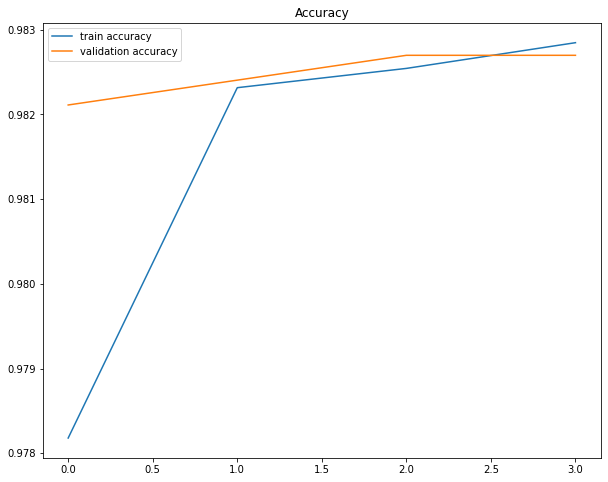

In [25]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

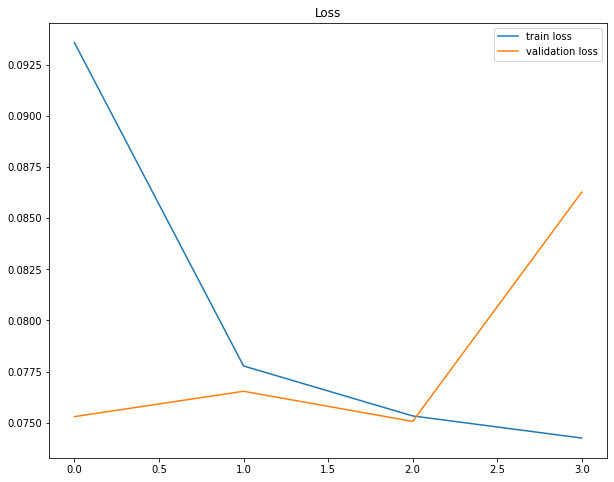

In [26]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Loss')
plt.show()

# Evaluación del Modelo

In [27]:
model.evaluate(x_test, y_test, batch_size=32)

106/106 [==============================] - 78s 740ms/step - loss: 0.0920 - accuracy: 0.9804


[0.09197647869586945, 0.9803863167762756]

In [28]:
y_pred = np.argmax(model.predict(x_test), axis=1)
print(classification_report(y_pred, y_test))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3359
           1       0.02      0.17      0.03         6

    accuracy                           0.98      3365
   macro avg       0.51      0.57      0.51      3365
weighted avg       1.00      0.98      0.99      3365



# Matriz de confusión

[Text(0, 0.5, 'Negativos'), Text(0, 1.5, 'Positivos')]

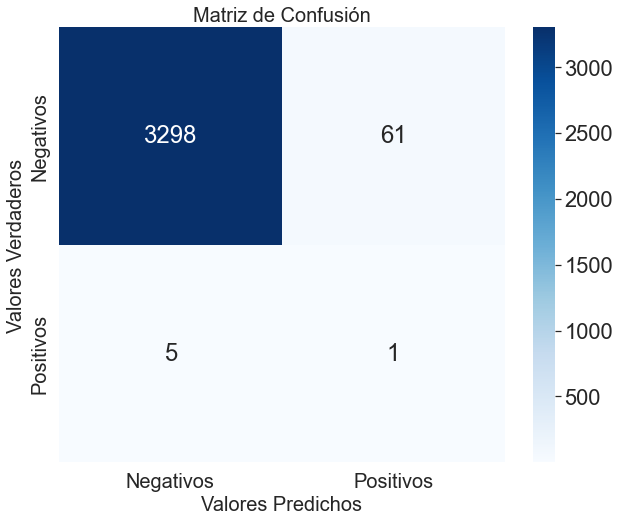

In [31]:
confusion = confusion_matrix(y_pred, y_test)

plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(confusion, annot=True, fmt='g', cmap="Blues", ax=ax)

# labels, title and ticks
ax.set_xlabel('Valores Predichos', fontsize=20)
ax.set_ylabel('Valores Verdaderos', fontsize=20)
ax.set_title('Matriz de Confusión', fontsize=20)
ax.xaxis.set_ticklabels(['Negativos', 'Positivos'], fontsize=20)
ax.yaxis.set_ticklabels(['Negativos', 'Positivos'], fontsize=20)


In [32]:
f1_score(y_test, y_pred, average='micro')

0.9803863298662704

In [33]:
recall_score(y_test, y_pred, average='weighted')

0.9803863298662704

In [34]:
precision_score(y_test, y_pred, average='micro')

0.9803863298662704

# Guardar el modelo

In [36]:
model.save('./models/train_vgg19')

INFO:tensorflow:Assets written to: ./models/train_vgg19\assets
